In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
import torch.optim as optim
from torchvision import datasets,transforms
from model import *
import math

# Utils

## Dataset

In [4]:
class FashionMNIST_class(Dataset):
    def __init__(self, cl, train = True):
        super().__init__()
        data = datasets.FashionMNIST(root = "data", train = train, download = True, transform= transforms.ToTensor())
        X = data.data
        y = data.targets
        self.X = X[y == cl]
        self.y = cl * np.ones(self.X.shape[0])
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        x = torch.tensor(self.X[index], dtype = torch.float)
        y = torch.tensor(self.y[index], dtype= torch.long)
        return x, y


In [8]:
## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()


In [9]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are drawn from real dataset
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    real_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 1 here because we expect prediction to be 
    # 1 (or near 1) since samples are drawn from real dataset
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are generated fake samples
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 0 here because we expect prediction to be 
    # 0 (or near 0) since samples are generated fake samples
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss 

In [10]:
# Training loop function

def train_minst_gan(d, g, z_size, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    
    # Generate a batch (say 16) of latent image vector (z) of fixed size 
    # (say 100 pix) to be as input to the Generator after each epoch of 
    # training to generate a fake image. We'll visualise these fake images
    # to get a sense how generator improves as training progresses
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    
    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)
    
    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            # Move input batch to available device
            real_images = real_images.to(device)
            
            ## ----------------------------------------------------------------
            ## Train discriminator using real and then fake MNIST images,  
            ## then compute the total-loss and back-propogate the total-loss
            ## ----------------------------------------------------------------
            
            # Reset gradients
            d_optim.zero_grad()
            
            # Real MNIST images
            # Convert real_images value range of 0 to 1 to -1 to 1
            # this is required because latter discriminator would be required 
            # to consume generator's 'tanh' output which is of range -1 to 1
            real_images = ((real_images / 255) * 2) - 1  
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            #d_real_loss = real_loss(d_real_logits_out, smooth=True)
            
            # Fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors 
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # Generate batch of fake images
                fake_images = g(z) 
            # feed fake-images to discriminator and compute the 
            # fake_loss (i.e. target label = 0)
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            #d_fake_loss = fake_loss(d_fake_logits_out)
            # Compute total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            # Backpropogate through discriminator
            d_loss.backward()
            d_optim.step()
            # Save discriminator batch loss
            d_running_batch_loss += d_loss
            
            ## ----------------------------------------------------------------
            ## Train generator, compute the generator loss which is a measure
            ## of how successful the generator is in tricking the discriminator 
            ## and finally back-propogate generator loss
            ## ----------------------------------------------------------------

            # Reset gradients
            g_optim.zero_grad()
            
            # Generate a batch of random latent vectors
            #z = torch.rand(size=(dl.batch_size, z_size)).to(device)
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            # Generate a batch of fake images, feed them to discriminator
            # and compute the generator loss as real_loss 
            # (i.e. target label = 1)
            fake_images = g(z) 
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            #g_loss = real_loss(g_logits_out)
            # Backpropogate thorugh generator
            g_loss.backward()
            g_optim.step()
            # Save discriminator batch loss
            g_running_batch_loss += g_loss
            
            # Display training stats for every 200 batches 
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')
            
        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        # Display training stats for every 200 batches 
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')
        
        # Generate fake images from fixed latent vector using the trained 
        # generator so far and save images for latter viewing
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())
        
    # Finally write generated fake images from fixed latent vector to disk
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)
     
    return d_losses, g_losses

In [11]:
##
## Visualize image generation improvements
##

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)  
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1 
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, height, width = len(epoch_data), 28, 28
    image_batch = epoch_data.view(batch_size, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

# Class 0

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


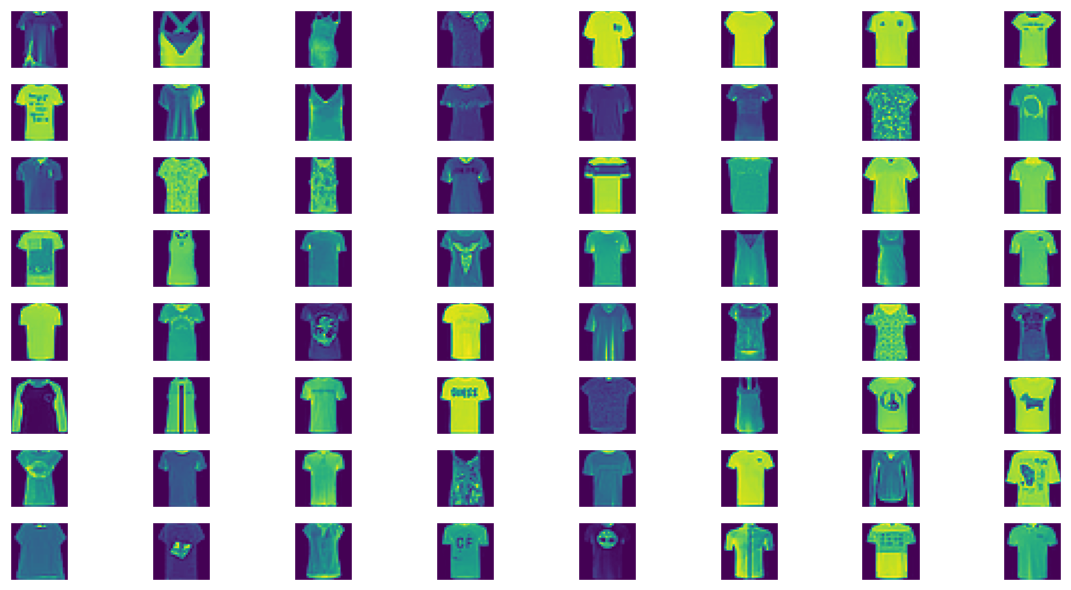

In [20]:
cl = 0
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [21]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.891045 	epoch_g_loss: 1.547989
Epoch [2/400]:
epoch_d_loss: 0.682522 	epoch_g_loss: 2.763399
Epoch [3/400]:
epoch_d_loss: 0.651407 	epoch_g_loss: 4.069422
Epoch [4/400]:
epoch_d_loss: 0.508099 	epoch_g_loss: 5.369004
Epoch [5/400]:
epoch_d_loss: 0.429450 	epoch_g_loss: 5.510772
Epoch [6/400]:
epoch_d_loss: 0.665140 	epoch_g_loss: 4.213683
Epoch [7/400]:
epoch_d_loss: 0.523133 	epoch_g_loss: 3.394550
Epoch [8/400]:
epoch_d_loss: 0.801414 	epoch_g_loss: 2.065579
Epoch [9/400]:
epoch_d_loss: 0.688992 	epoch_g_loss: 2.420892
Epoch [10/400]:
epoch_d_loss: 0.680424 	epoch_g_loss: 2.649134
Epoch [11/400]:
epoch_d_loss: 0.667090 	epoch_g_loss: 2.116821
Epoch [12/400]:
epoch_d_loss: 0.522886 	epoch_g_loss: 2.975872
Epoch [13/400]:
epoch_d_loss: 0.521276 	epoch_g_loss: 3.483486
Epoch [14/400]:
epoch_d_loss: 0.536395 	epoch_g_loss: 3.678784
Epoch [15/400]:
epoch_d_loss: 0.717860 	epoch_g_loss: 2.618930
Epoch [16/400]:
epoch_d_loss: 0.703401 	epoch_g_loss: 2.169273
Epoch [17/400]:


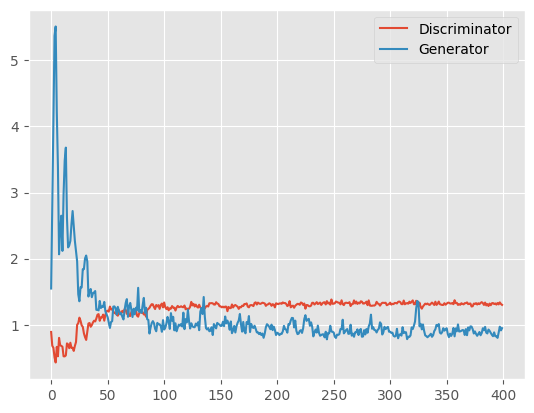

In [22]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

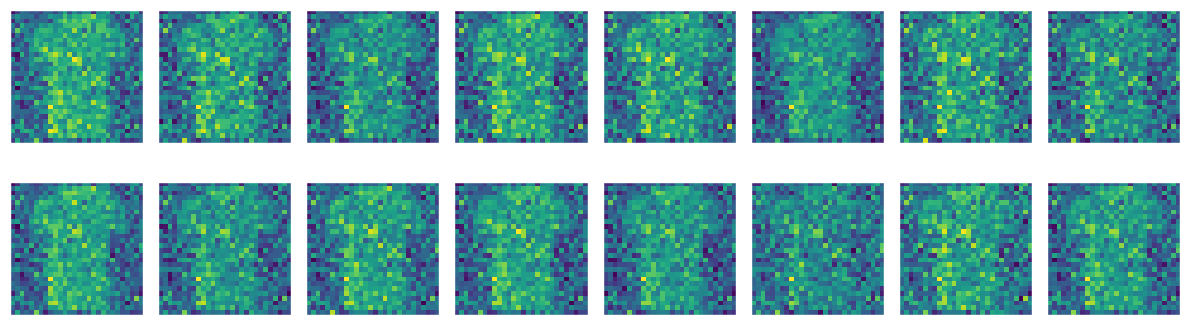

In [23]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

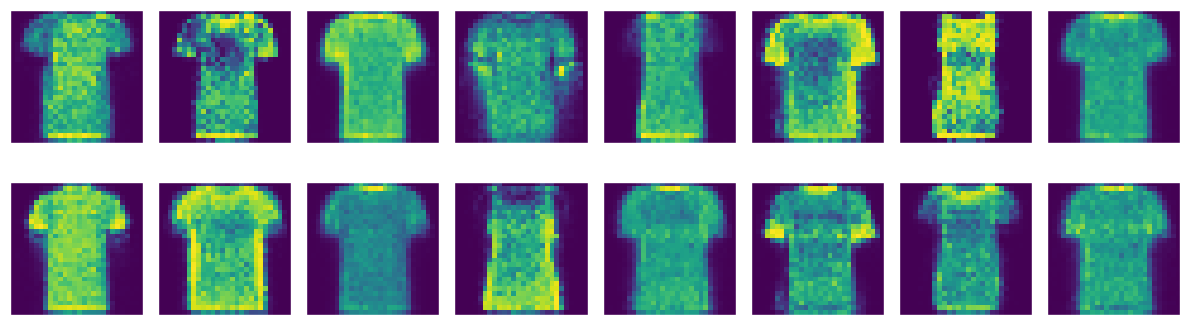

In [24]:
show_generated_images(epoch=400, n_cols=8)

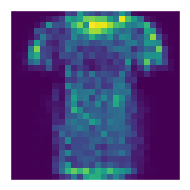

The discriminator s opinion is :  0.05022072792053223


In [25]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [26]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 1

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


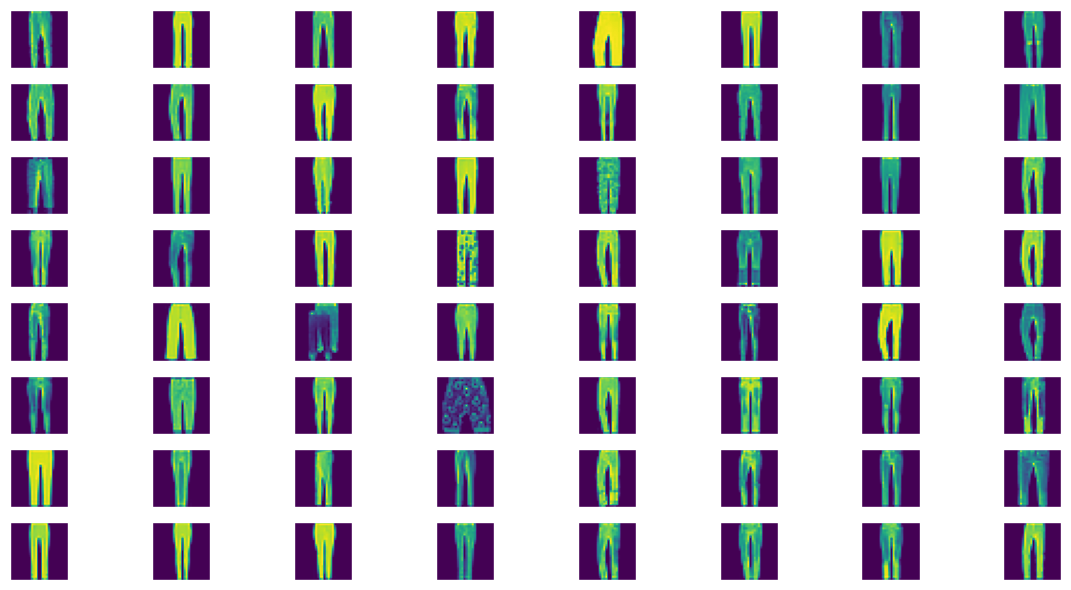

In [27]:
cl = 1
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [28]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.614944 	epoch_g_loss: 2.203109
Epoch [2/400]:
epoch_d_loss: 0.451842 	epoch_g_loss: 3.613185
Epoch [3/400]:
epoch_d_loss: 0.495378 	epoch_g_loss: 5.648949
Epoch [4/400]:
epoch_d_loss: 0.390859 	epoch_g_loss: 5.585327
Epoch [5/400]:
epoch_d_loss: 0.631380 	epoch_g_loss: 5.271241
Epoch [6/400]:
epoch_d_loss: 0.665852 	epoch_g_loss: 3.563593
Epoch [7/400]:
epoch_d_loss: 0.512966 	epoch_g_loss: 5.143616
Epoch [8/400]:
epoch_d_loss: 0.445020 	epoch_g_loss: 5.406867
Epoch [9/400]:
epoch_d_loss: 0.437089 	epoch_g_loss: 3.691750
Epoch [10/400]:
epoch_d_loss: 0.357019 	epoch_g_loss: 3.774888
Epoch [11/400]:
epoch_d_loss: 0.255456 	epoch_g_loss: 4.303045
Epoch [12/400]:
epoch_d_loss: 0.350430 	epoch_g_loss: 3.750466
Epoch [13/400]:
epoch_d_loss: 0.623010 	epoch_g_loss: 3.391427
Epoch [14/400]:
epoch_d_loss: 0.586200 	epoch_g_loss: 2.831252
Epoch [15/400]:
epoch_d_loss: 0.594006 	epoch_g_loss: 2.588855
Epoch [16/400]:
epoch_d_loss: 0.522592 	epoch_g_loss: 2.565420
Epoch [17/400]:


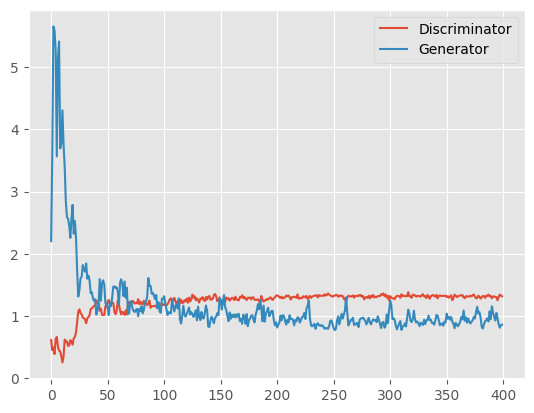

In [29]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

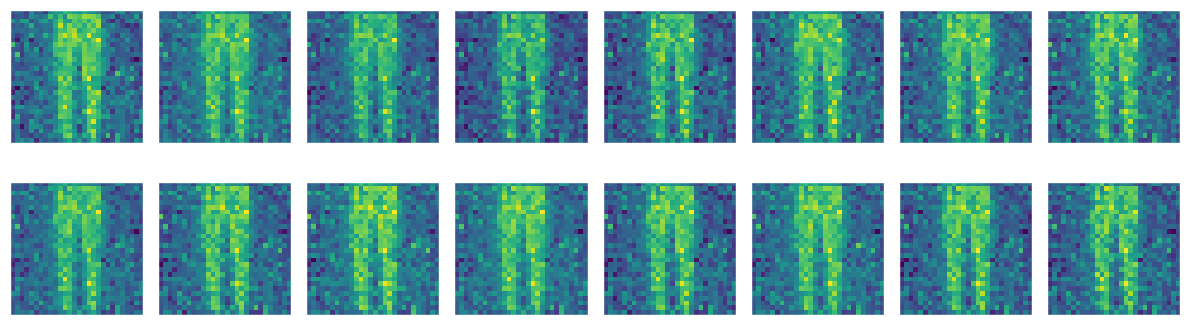

In [30]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

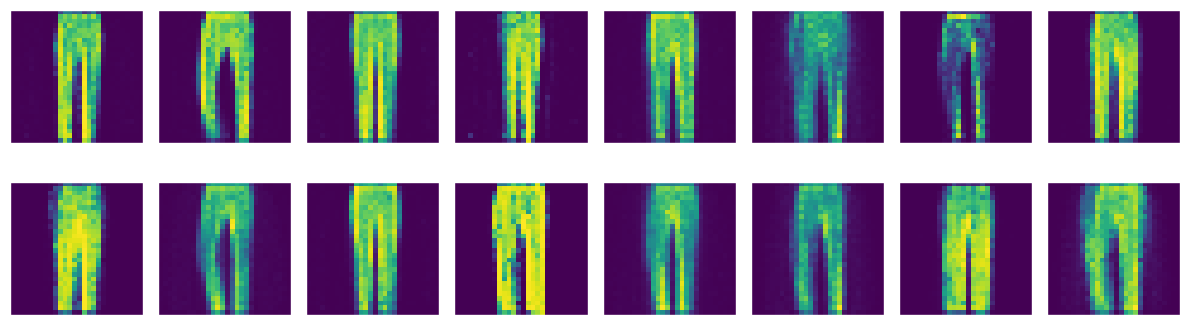

In [31]:
show_generated_images(epoch=400, n_cols=8)

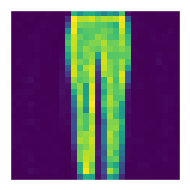

The discriminator s opinion is :  -0.1843695342540741


In [32]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [33]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 2

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


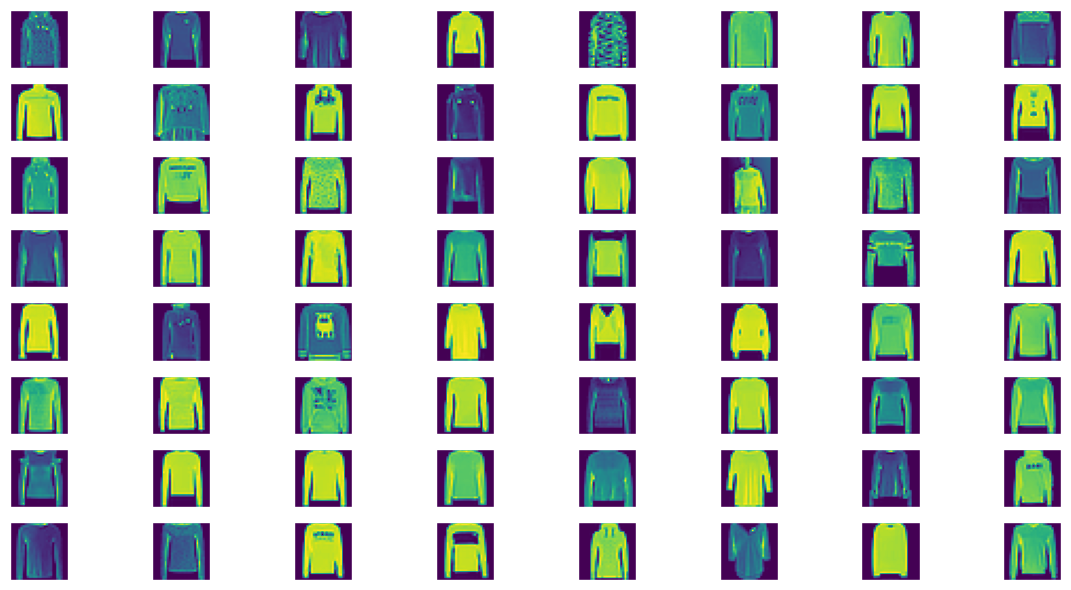

In [35]:
cl = 2
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [36]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.754400 	epoch_g_loss: 1.418422
Epoch [2/400]:
epoch_d_loss: 0.623517 	epoch_g_loss: 2.858186
Epoch [3/400]:
epoch_d_loss: 0.390813 	epoch_g_loss: 4.730746
Epoch [4/400]:
epoch_d_loss: 0.373531 	epoch_g_loss: 4.803699
Epoch [5/400]:
epoch_d_loss: 0.443636 	epoch_g_loss: 5.310844
Epoch [6/400]:
epoch_d_loss: 0.734537 	epoch_g_loss: 4.080653
Epoch [7/400]:
epoch_d_loss: 0.684452 	epoch_g_loss: 3.423659
Epoch [8/400]:
epoch_d_loss: 0.472902 	epoch_g_loss: 4.134953
Epoch [9/400]:
epoch_d_loss: 0.430390 	epoch_g_loss: 4.185120
Epoch [10/400]:
epoch_d_loss: 0.348325 	epoch_g_loss: 3.619913
Epoch [11/400]:
epoch_d_loss: 0.540333 	epoch_g_loss: 3.105677
Epoch [12/400]:
epoch_d_loss: 0.708356 	epoch_g_loss: 2.802359
Epoch [13/400]:
epoch_d_loss: 0.491206 	epoch_g_loss: 2.749851
Epoch [14/400]:
epoch_d_loss: 0.512644 	epoch_g_loss: 3.048252
Epoch [15/400]:
epoch_d_loss: 0.539936 	epoch_g_loss: 3.073330
Epoch [16/400]:
epoch_d_loss: 0.783561 	epoch_g_loss: 2.365254
Epoch [17/400]:


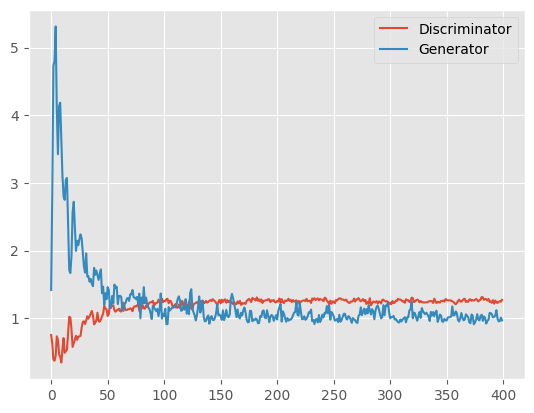

In [37]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

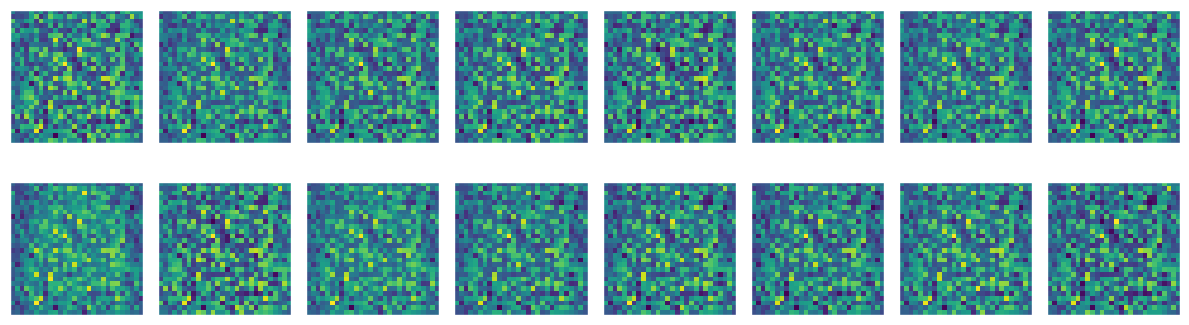

In [38]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

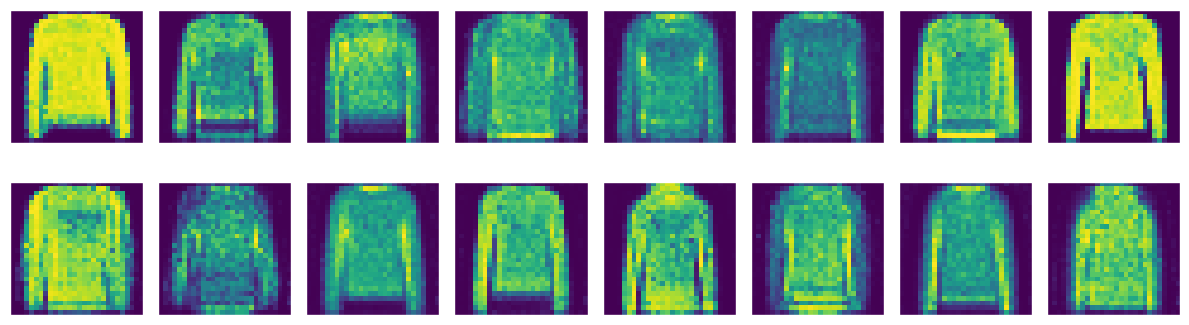

In [39]:
show_generated_images(epoch=400, n_cols=8)

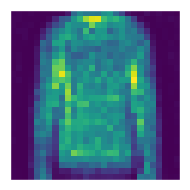

The discriminator s opinion is :  -0.5959458351135254


In [40]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [41]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 3

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


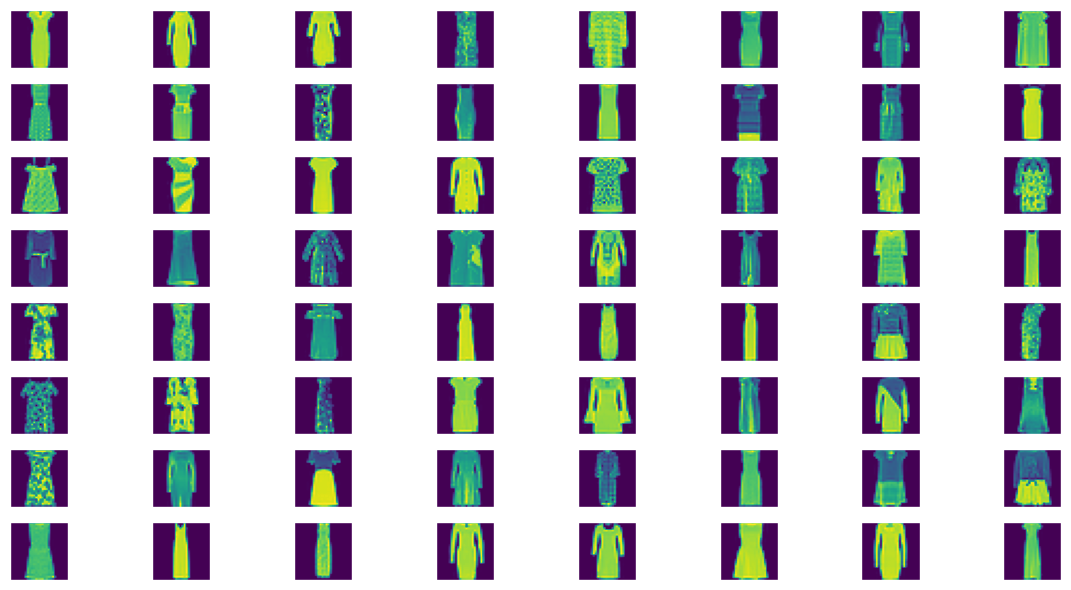

In [42]:
cl = 3
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [43]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.850115 	epoch_g_loss: 1.390994
Epoch [2/400]:
epoch_d_loss: 0.627808 	epoch_g_loss: 2.391987
Epoch [3/400]:
epoch_d_loss: 0.780982 	epoch_g_loss: 3.493736
Epoch [4/400]:
epoch_d_loss: 0.918018 	epoch_g_loss: 2.620105
Epoch [5/400]:
epoch_d_loss: 0.921911 	epoch_g_loss: 3.072889
Epoch [6/400]:
epoch_d_loss: 0.902498 	epoch_g_loss: 3.245228
Epoch [7/400]:
epoch_d_loss: 0.811153 	epoch_g_loss: 3.124640
Epoch [8/400]:
epoch_d_loss: 0.917050 	epoch_g_loss: 3.229301
Epoch [9/400]:
epoch_d_loss: 1.074096 	epoch_g_loss: 1.774848
Epoch [10/400]:
epoch_d_loss: 0.806502 	epoch_g_loss: 2.190162
Epoch [11/400]:
epoch_d_loss: 0.917989 	epoch_g_loss: 1.690864
Epoch [12/400]:
epoch_d_loss: 0.762542 	epoch_g_loss: 2.037742
Epoch [13/400]:
epoch_d_loss: 0.850821 	epoch_g_loss: 2.017175
Epoch [14/400]:
epoch_d_loss: 0.823997 	epoch_g_loss: 2.359759
Epoch [15/400]:
epoch_d_loss: 0.709191 	epoch_g_loss: 2.150781
Epoch [16/400]:
epoch_d_loss: 0.733355 	epoch_g_loss: 2.009563
Epoch [17/400]:


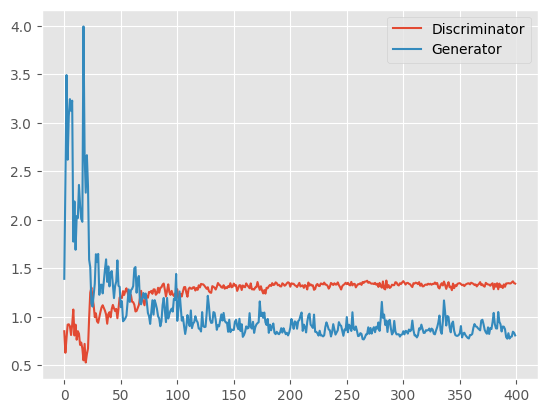

In [44]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

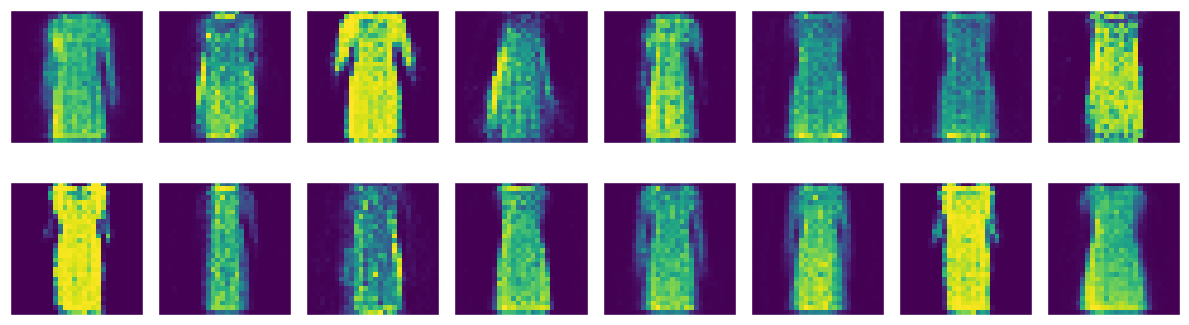

In [45]:
show_generated_images(epoch=400, n_cols=8)

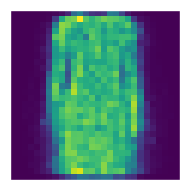

The discriminator s opinion is :  -0.3965717554092407


In [46]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [47]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 4

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


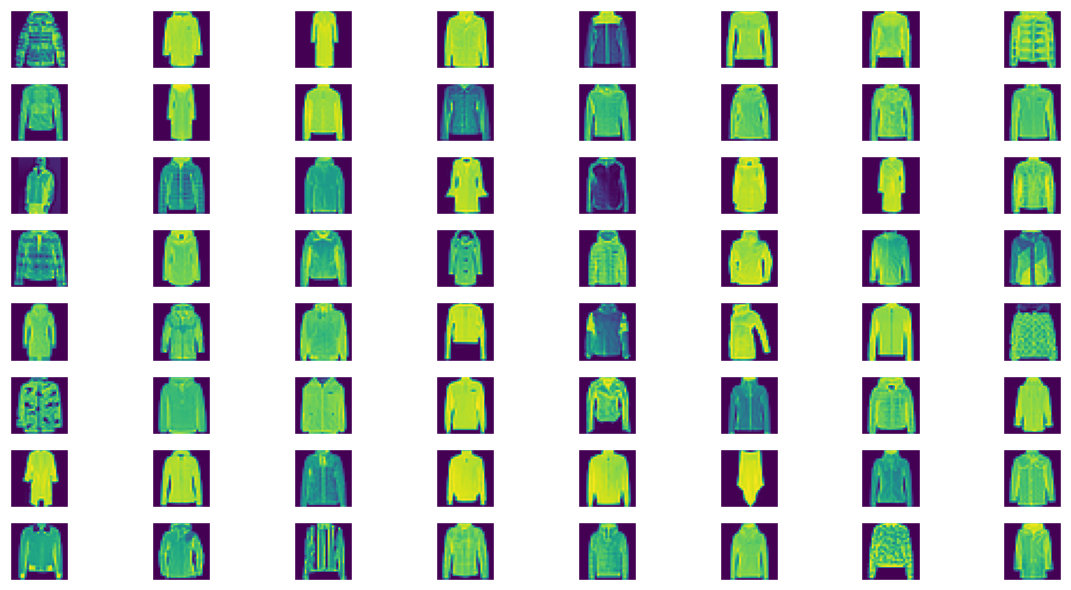

In [48]:
cl = 4
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [49]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.675710 	epoch_g_loss: 2.229491
Epoch [2/400]:
epoch_d_loss: 0.668325 	epoch_g_loss: 3.347434
Epoch [3/400]:
epoch_d_loss: 0.616117 	epoch_g_loss: 3.594631
Epoch [4/400]:
epoch_d_loss: 0.772923 	epoch_g_loss: 4.279882
Epoch [5/400]:
epoch_d_loss: 0.680758 	epoch_g_loss: 4.397656
Epoch [6/400]:
epoch_d_loss: 0.539602 	epoch_g_loss: 5.521564
Epoch [7/400]:
epoch_d_loss: 0.577069 	epoch_g_loss: 4.491379
Epoch [8/400]:
epoch_d_loss: 0.462804 	epoch_g_loss: 4.581036
Epoch [9/400]:
epoch_d_loss: 0.620020 	epoch_g_loss: 3.664552
Epoch [10/400]:
epoch_d_loss: 0.740200 	epoch_g_loss: 2.955418
Epoch [11/400]:
epoch_d_loss: 0.763266 	epoch_g_loss: 2.815921
Epoch [12/400]:
epoch_d_loss: 0.610248 	epoch_g_loss: 2.326431
Epoch [13/400]:
epoch_d_loss: 0.632103 	epoch_g_loss: 2.266866
Epoch [14/400]:
epoch_d_loss: 0.561251 	epoch_g_loss: 2.836037
Epoch [15/400]:
epoch_d_loss: 0.619492 	epoch_g_loss: 3.685781
Epoch [16/400]:
epoch_d_loss: 0.558623 	epoch_g_loss: 3.230163
Epoch [17/400]:


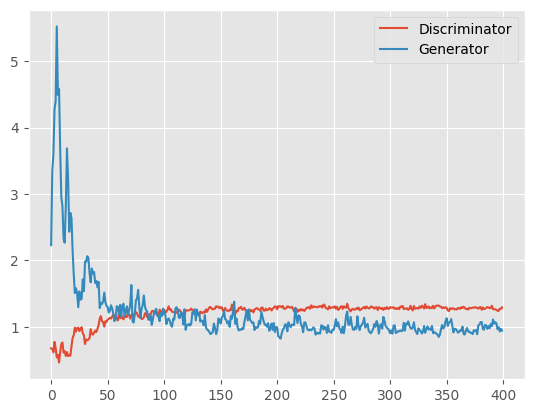

In [50]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

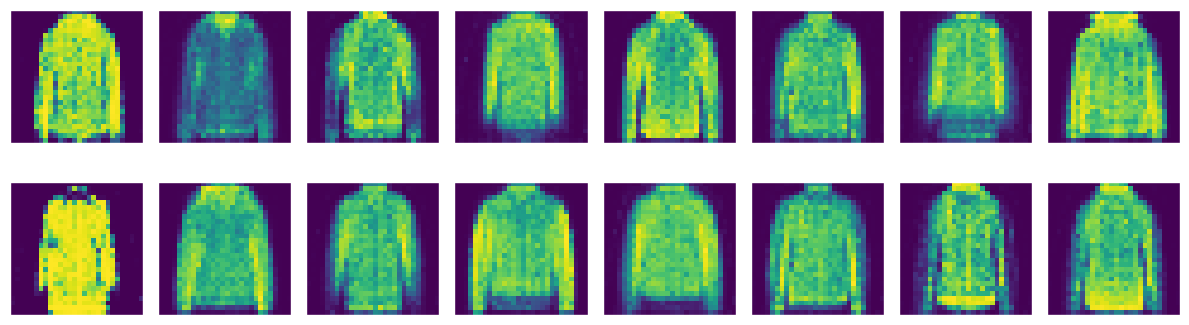

In [51]:
show_generated_images(epoch=400, n_cols=8)

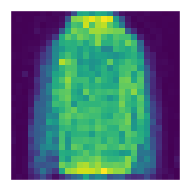

The discriminator s opinion is :  0.19729894399642944


In [52]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [53]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 5

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


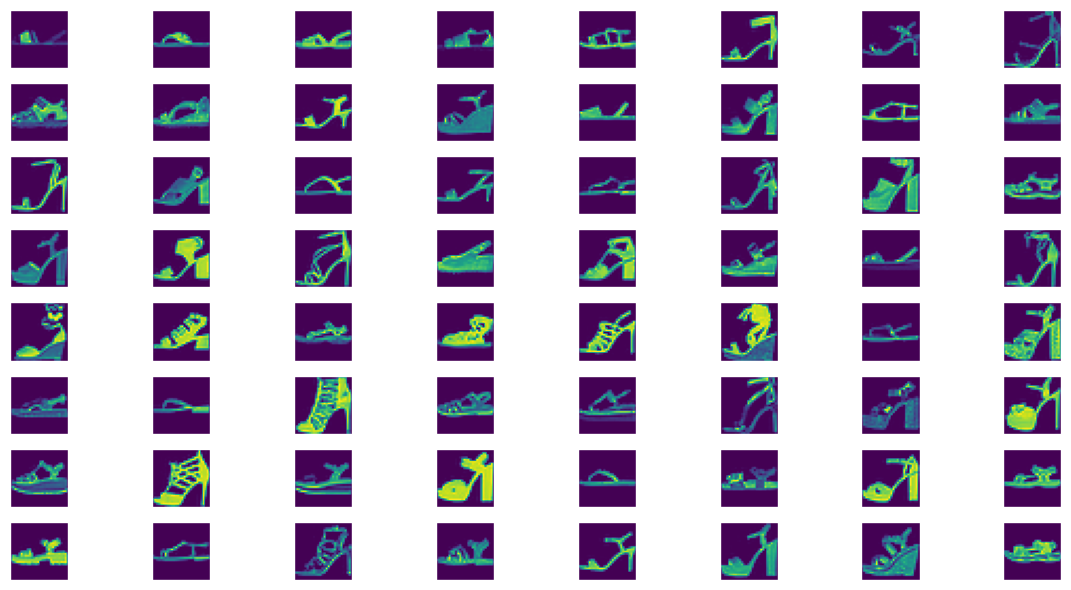

In [54]:
cl = 5
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [55]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.855663 	epoch_g_loss: 1.337270
Epoch [2/400]:
epoch_d_loss: 0.650068 	epoch_g_loss: 2.272735
Epoch [3/400]:
epoch_d_loss: 0.616761 	epoch_g_loss: 3.510776
Epoch [4/400]:
epoch_d_loss: 0.651242 	epoch_g_loss: 3.946472
Epoch [5/400]:
epoch_d_loss: 0.940410 	epoch_g_loss: 3.486982
Epoch [6/400]:
epoch_d_loss: 0.818857 	epoch_g_loss: 2.762014
Epoch [7/400]:
epoch_d_loss: 0.882499 	epoch_g_loss: 2.403738
Epoch [8/400]:
epoch_d_loss: 0.643355 	epoch_g_loss: 2.958710
Epoch [9/400]:
epoch_d_loss: 0.491599 	epoch_g_loss: 3.197950
Epoch [10/400]:
epoch_d_loss: 0.492728 	epoch_g_loss: 3.500358
Epoch [11/400]:
epoch_d_loss: 0.439358 	epoch_g_loss: 3.206012
Epoch [12/400]:
epoch_d_loss: 0.404216 	epoch_g_loss: 3.184395
Epoch [13/400]:
epoch_d_loss: 0.487665 	epoch_g_loss: 2.714573
Epoch [14/400]:
epoch_d_loss: 0.797055 	epoch_g_loss: 1.781236
Epoch [15/400]:
epoch_d_loss: 0.816097 	epoch_g_loss: 1.929822
Epoch [16/400]:
epoch_d_loss: 0.858384 	epoch_g_loss: 2.102901
Epoch [17/400]:


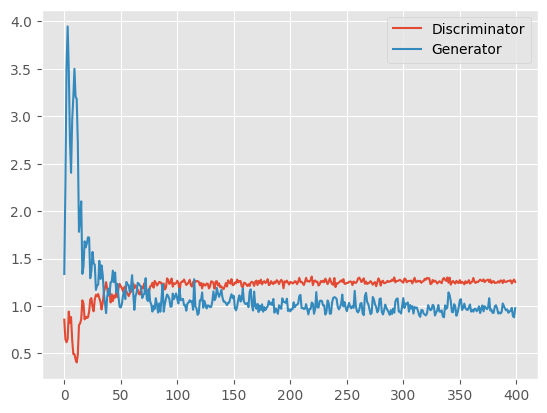

In [56]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

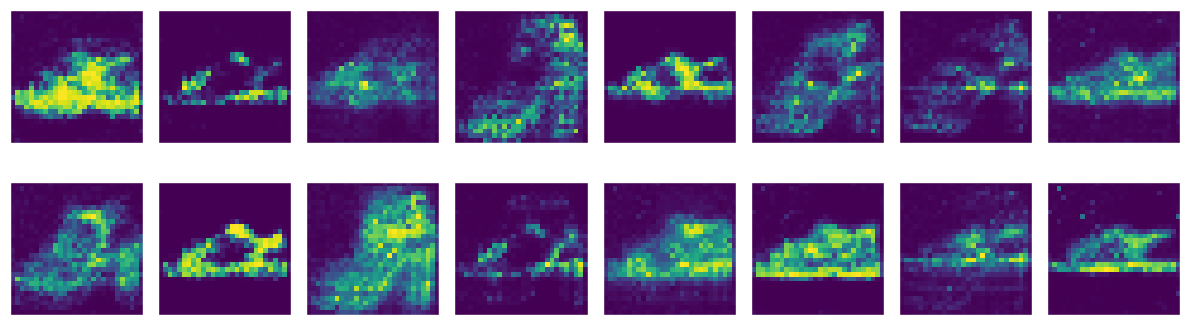

In [57]:
show_generated_images(epoch=400, n_cols=8)

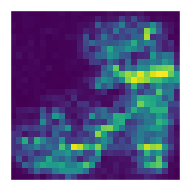

The discriminator s opinion is :  -0.6026149988174438


In [58]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [59]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 6

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


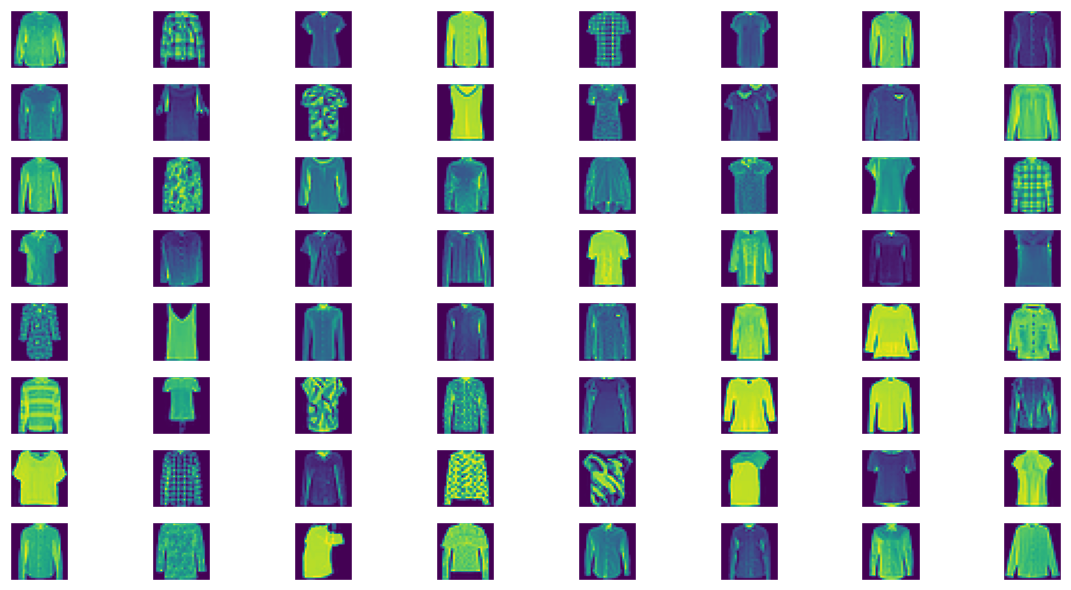

In [64]:
cl = 6
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [65]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.813374 	epoch_g_loss: 1.252599
Epoch [2/400]:
epoch_d_loss: 0.510824 	epoch_g_loss: 3.727220
Epoch [3/400]:
epoch_d_loss: 0.372127 	epoch_g_loss: 3.759319
Epoch [4/400]:
epoch_d_loss: 0.375608 	epoch_g_loss: 5.004074
Epoch [5/400]:
epoch_d_loss: 0.612090 	epoch_g_loss: 5.226995
Epoch [6/400]:
epoch_d_loss: 0.782296 	epoch_g_loss: 3.864579
Epoch [7/400]:
epoch_d_loss: 0.731002 	epoch_g_loss: 3.270951
Epoch [8/400]:
epoch_d_loss: 0.426975 	epoch_g_loss: 4.173255
Epoch [9/400]:
epoch_d_loss: 0.441557 	epoch_g_loss: 4.141242
Epoch [10/400]:
epoch_d_loss: 0.701295 	epoch_g_loss: 3.237397
Epoch [11/400]:
epoch_d_loss: 0.631068 	epoch_g_loss: 3.386941
Epoch [12/400]:
epoch_d_loss: 0.785742 	epoch_g_loss: 2.522460
Epoch [13/400]:
epoch_d_loss: 0.703635 	epoch_g_loss: 2.513913
Epoch [14/400]:
epoch_d_loss: 0.639723 	epoch_g_loss: 2.696563
Epoch [15/400]:
epoch_d_loss: 0.578497 	epoch_g_loss: 3.083693
Epoch [16/400]:
epoch_d_loss: 0.573963 	epoch_g_loss: 2.769537
Epoch [17/400]:


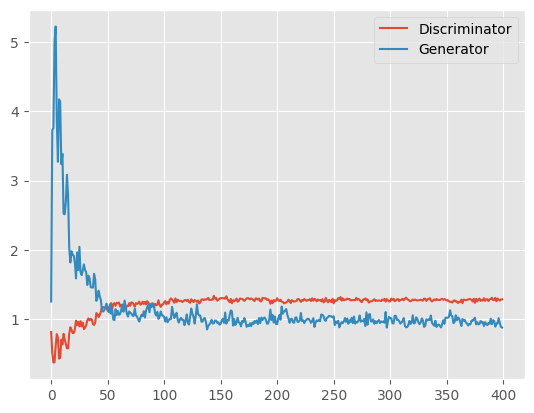

In [66]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

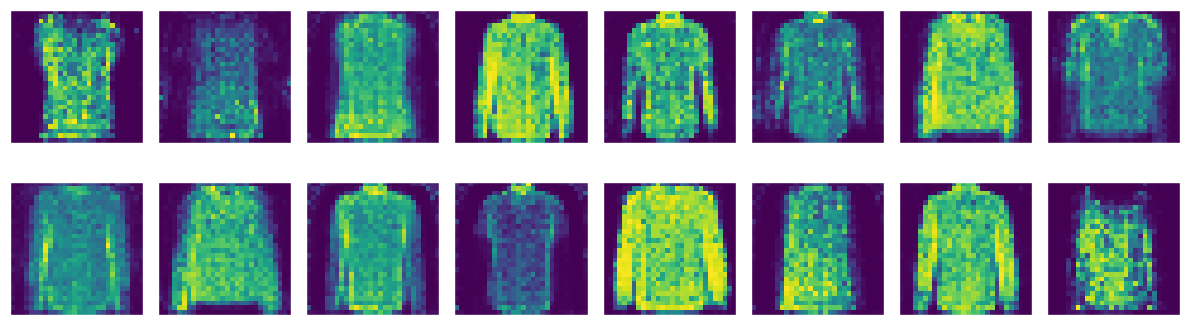

In [67]:
show_generated_images(epoch=400, n_cols=8)

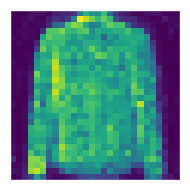

The discriminator s opinion is :  -0.5955015420913696


In [68]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [69]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 7

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


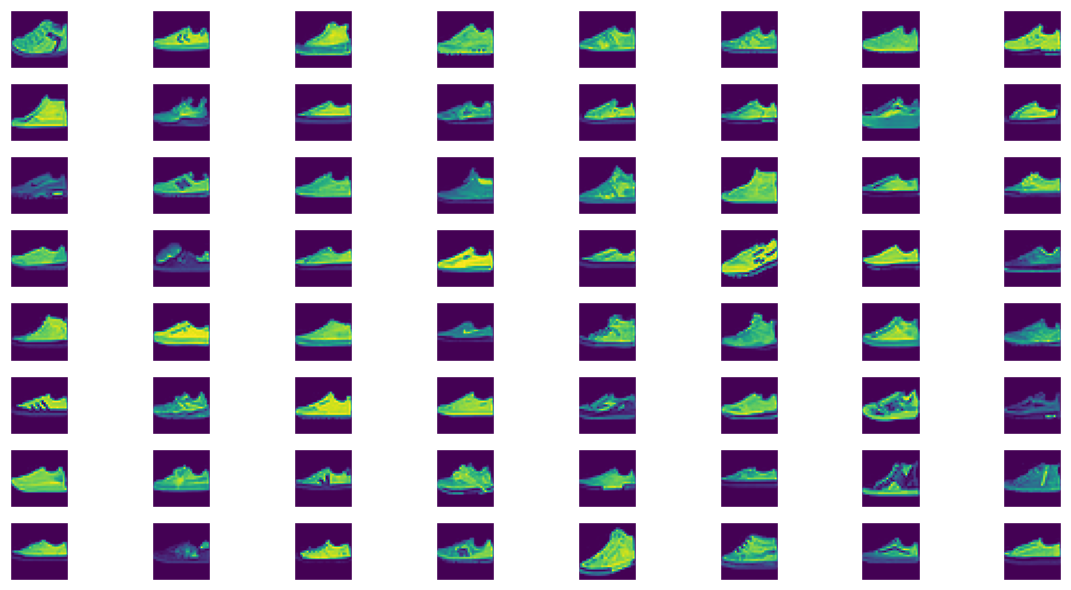

In [70]:
cl = 7
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [71]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.892282 	epoch_g_loss: 1.306131
Epoch [2/400]:
epoch_d_loss: 0.669587 	epoch_g_loss: 2.388437
Epoch [3/400]:
epoch_d_loss: 0.563100 	epoch_g_loss: 4.055870
Epoch [4/400]:
epoch_d_loss: 0.659938 	epoch_g_loss: 4.327375
Epoch [5/400]:
epoch_d_loss: 0.712683 	epoch_g_loss: 5.691230
Epoch [6/400]:
epoch_d_loss: 0.920403 	epoch_g_loss: 2.875591
Epoch [7/400]:
epoch_d_loss: 0.818017 	epoch_g_loss: 3.538995
Epoch [8/400]:
epoch_d_loss: 0.615022 	epoch_g_loss: 5.949013
Epoch [9/400]:
epoch_d_loss: 0.975188 	epoch_g_loss: 2.241326
Epoch [10/400]:
epoch_d_loss: 0.786301 	epoch_g_loss: 2.413676
Epoch [11/400]:
epoch_d_loss: 0.644098 	epoch_g_loss: 2.618950
Epoch [12/400]:
epoch_d_loss: 0.634655 	epoch_g_loss: 2.785284
Epoch [13/400]:
epoch_d_loss: 0.522200 	epoch_g_loss: 3.594830
Epoch [14/400]:
epoch_d_loss: 0.446362 	epoch_g_loss: 3.704572
Epoch [15/400]:
epoch_d_loss: 0.541267 	epoch_g_loss: 2.773970
Epoch [16/400]:
epoch_d_loss: 0.835115 	epoch_g_loss: 2.088867
Epoch [17/400]:


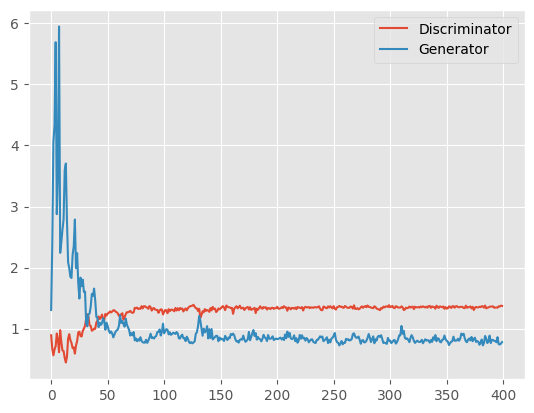

In [72]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

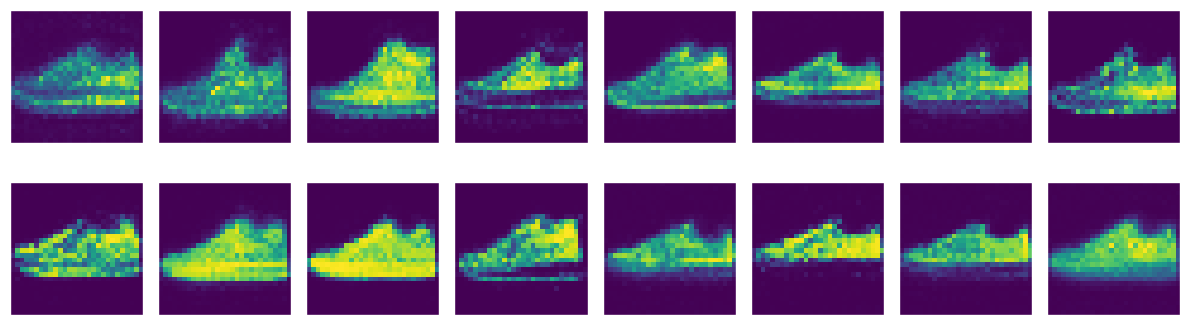

In [73]:
show_generated_images(epoch=400, n_cols=8)

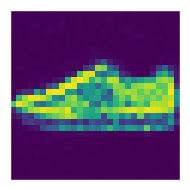

The discriminator s opinion is :  -1.0709912776947021


In [74]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [75]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 8

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


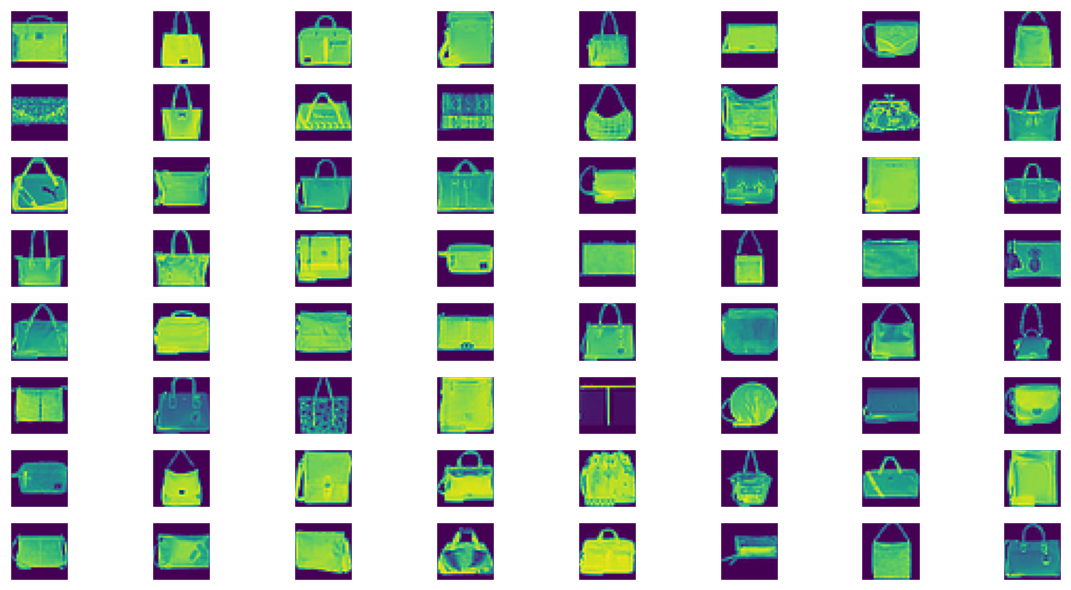

In [85]:
cl = 8
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [86]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.AdamW(d.parameters(), lr=0.002)
g_optim = optim.AdamW(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.698546 	epoch_g_loss: 1.942718
Epoch [2/400]:
epoch_d_loss: 0.605643 	epoch_g_loss: 3.487939
Epoch [3/400]:
epoch_d_loss: 0.419590 	epoch_g_loss: 5.086297
Epoch [4/400]:
epoch_d_loss: 0.266227 	epoch_g_loss: 5.214266
Epoch [5/400]:
epoch_d_loss: 0.186056 	epoch_g_loss: 5.549177
Epoch [6/400]:
epoch_d_loss: 0.116764 	epoch_g_loss: 5.666603
Epoch [7/400]:
epoch_d_loss: 0.490035 	epoch_g_loss: 3.984762
Epoch [8/400]:
epoch_d_loss: 0.301831 	epoch_g_loss: 3.738653
Epoch [9/400]:
epoch_d_loss: 0.280781 	epoch_g_loss: 4.099121
Epoch [10/400]:
epoch_d_loss: 0.401214 	epoch_g_loss: 3.492087
Epoch [11/400]:
epoch_d_loss: 0.479287 	epoch_g_loss: 3.306807
Epoch [12/400]:
epoch_d_loss: 0.821387 	epoch_g_loss: 2.259738
Epoch [13/400]:
epoch_d_loss: 0.804747 	epoch_g_loss: 2.084812
Epoch [14/400]:
epoch_d_loss: 0.645563 	epoch_g_loss: 3.033777
Epoch [15/400]:
epoch_d_loss: 0.602032 	epoch_g_loss: 2.805292
Epoch [16/400]:
epoch_d_loss: 0.592411 	epoch_g_loss: 3.068484
Epoch [17/400]:


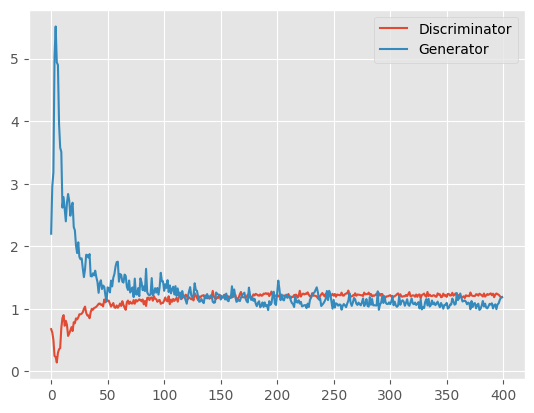

In [78]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

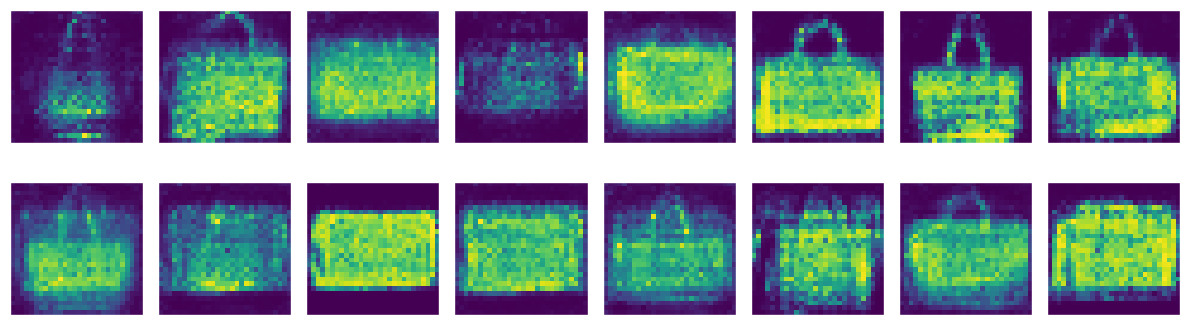

In [87]:
show_generated_images(epoch=400, n_cols=8)

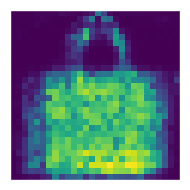

The discriminator s opinion is :  0.25028544664382935


In [88]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [89]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

# Class 9

/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


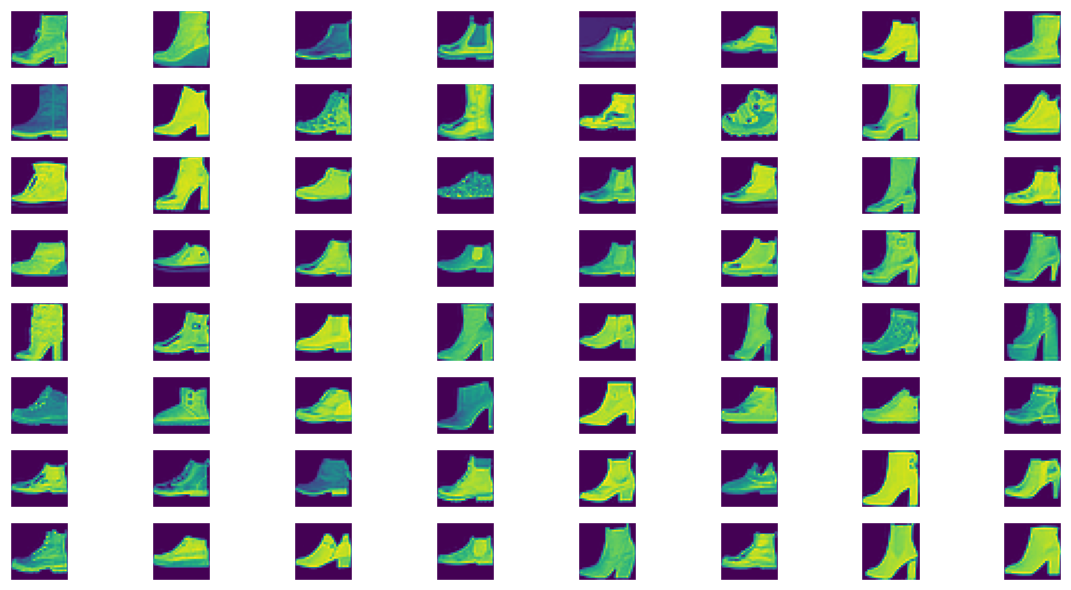

In [90]:
cl = 9
train_data = FashionMNIST_class(cl, True)
test_data = FashionMNIST_class(cl, False)

# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [91]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3616/1937068705.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.578896 	epoch_g_loss: 2.987227
Epoch [2/400]:
epoch_d_loss: 0.513168 	epoch_g_loss: 3.281062
Epoch [3/400]:
epoch_d_loss: 0.399161 	epoch_g_loss: 3.728853
Epoch [4/400]:
epoch_d_loss: 0.545986 	epoch_g_loss: 3.406105
Epoch [5/400]:
epoch_d_loss: 0.486048 	epoch_g_loss: 7.558982
Epoch [6/400]:
epoch_d_loss: 0.708172 	epoch_g_loss: 5.444129
Epoch [7/400]:
epoch_d_loss: 0.572821 	epoch_g_loss: 4.523041
Epoch [8/400]:
epoch_d_loss: 0.457270 	epoch_g_loss: 4.839394
Epoch [9/400]:
epoch_d_loss: 0.316394 	epoch_g_loss: 4.119932
Epoch [10/400]:
epoch_d_loss: 0.301167 	epoch_g_loss: 4.683361
Epoch [11/400]:
epoch_d_loss: 0.300171 	epoch_g_loss: 3.628254
Epoch [12/400]:
epoch_d_loss: 0.350141 	epoch_g_loss: 3.532229
Epoch [13/400]:
epoch_d_loss: 0.663631 	epoch_g_loss: 2.418106
Epoch [14/400]:
epoch_d_loss: 1.014721 	epoch_g_loss: 1.612913
Epoch [15/400]:
epoch_d_loss: 0.791351 	epoch_g_loss: 2.068112
Epoch [16/400]:
epoch_d_loss: 0.582144 	epoch_g_loss: 2.827512
Epoch [17/400]:


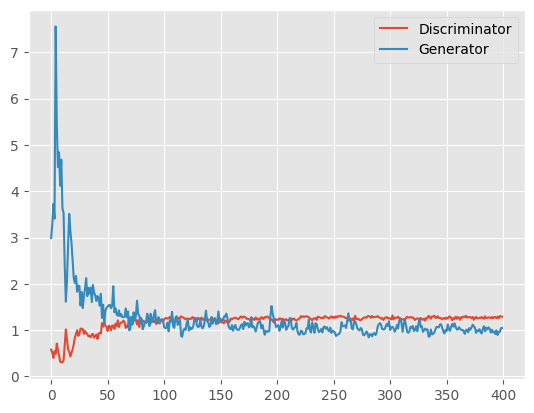

In [92]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

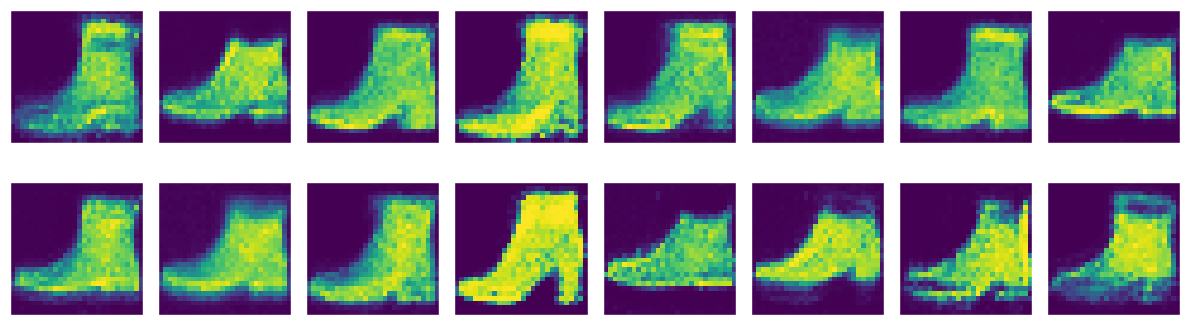

In [93]:
show_generated_images(epoch=400, n_cols=8)

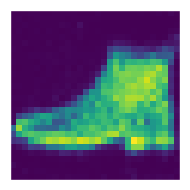

The discriminator s opinion is :  0.27781376242637634


In [94]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [95]:
torch.save(g.state_dict(), f'./models/gan-generator-fashionmnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./models/gan-discriminator-fashionmnist-cl-{cl}.pth')

## Some random tests

In [96]:
train_data = datasets.FashionMNIST(root = "data", train = True, download = True, transform= transforms.ToTensor())
#X = data.data
#y = data.targets
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()